#1. Install and Import Libraries
**Purpose:** Set up the environment for data analysis and modeling.

**Description:** Installs required packages (xgboost, lightgbm, imbalanced-learn, shap) and imports libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), and machine learning (scikit-learn, imblearn). Suppresses warnings for clean output.

In [1]:
# Install necessary packages (run this cell in Colab)
!pip install xgboost lightgbm imbalanced-learn shap

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import shap

#2. Load Datasets
**Purpose:** Load training and validation data for analysis.

**Description:** Reads the training (~25,000 records) and validation (~5,000 records) datasets containing features like LIMIT_BAL, age, pay_0, and the target next_month_default. Ensures data is ready for exploration and preprocessing.

In [2]:
# Load data
train = pd.read_csv('/content/train_dataset_final1.csv')
val   = pd.read_csv('/content/validate_dataset_final.csv')

#3. Summarize Data Characteristics
**Purpose:** Understand dataset structure and summary statistics.

**Description:** Displays the shape, columns, missing values, summary statistics, and default rate distribution of the training data. Highlights class imbalance in next_month_default and feature ranges to guide preprocessing.

In [4]:
# EDA: Summary Statistics and Data Overview
print("Training Data Shape:", train.shape)
print("Test Data Shape:", val.shape)
print("\nColumn Names:\n", train.columns.tolist())
print("\nMissing Values:\n", train.isnull().sum())
print("\nSummary Statistics:\n", train.describe())
print("\nDefault Rate Distribution:\n", train['next_month_default'].value_counts(normalize=True))
print("\nData Types:\n", train.dtypes)

Training Data Shape: (25247, 27)
Test Data Shape: (5016, 26)

Column Names:
 ['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'next_month_default']

Missing Values:
 Customer_ID             0
marriage                0
sex                     0
education               0
LIMIT_BAL               0
age                   126
pay_0                   0
pay_2                   0
pay_3                   0
pay_4                   0
pay_5                   0
pay_6                   0
Bill_amt1               0
Bill_amt2               0
Bill_amt3               0
Bill_amt4               0
Bill_amt5               0
Bill_amt6               0
pay_amt1                0
pay_amt2                0
pay_amt3                0
pay_amt4                0
pa

#4. Visualize Feature Distributions
**Purpose:** Examine distributions of key financial and demographic features.

**Description:** Plots histograms for LIMIT_BAL, age, and Bill_amt1 to assess skewness and outliers. These features influence credit risk, informing preprocessing steps like outlier capping and log-transformation.

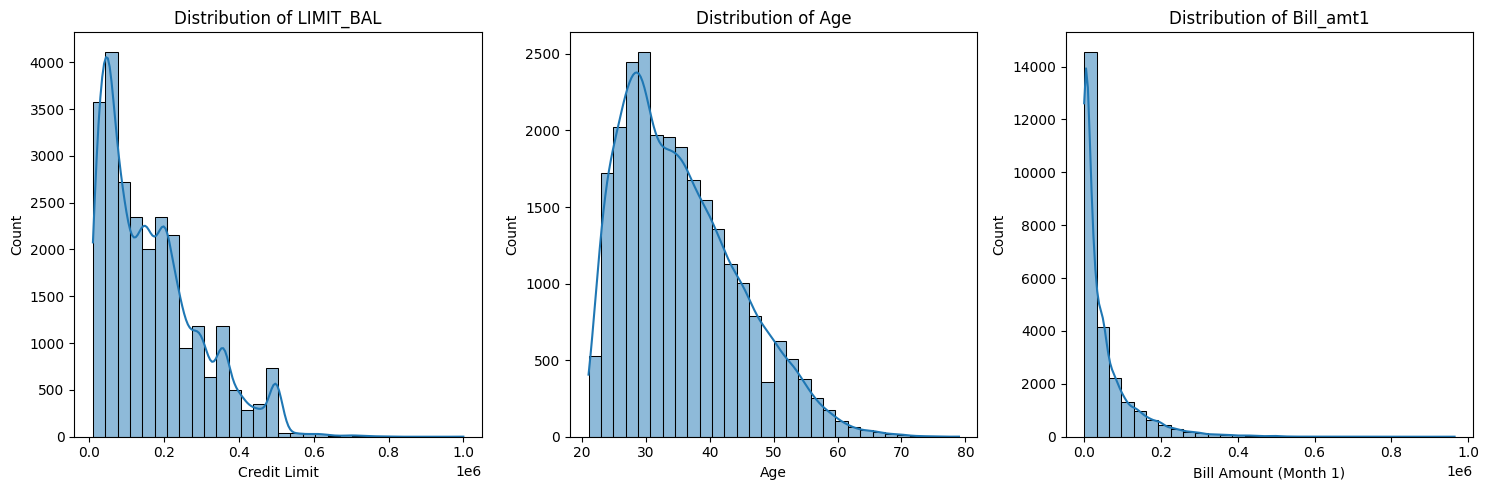

In [5]:
# EDA: Distribution of Key Numerical Features
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(train['LIMIT_BAL'], bins=30, kde=True)
plt.title('Distribution of LIMIT_BAL')
plt.xlabel('Credit Limit')
plt.ylabel('Count')
plt.subplot(1, 3, 2)
sns.histplot(train['age'].dropna(), bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.subplot(1, 3, 3)
sns.histplot(train['Bill_amt1'], bins=30, kde=True)
plt.title('Distribution of Bill_amt1')
plt.xlabel('Bill Amount (Month 1)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#5. Analyze Default Rates by Features
**Purpose:** Identify risk patterns across categorical and binned features.

**Description:** Visualizes default rates for sex, education, marriage, binned LIMIT_BAL, and pay_0. Bar plots reveal how repayment delays and credit limits correlate with default risk, providing financial insights.

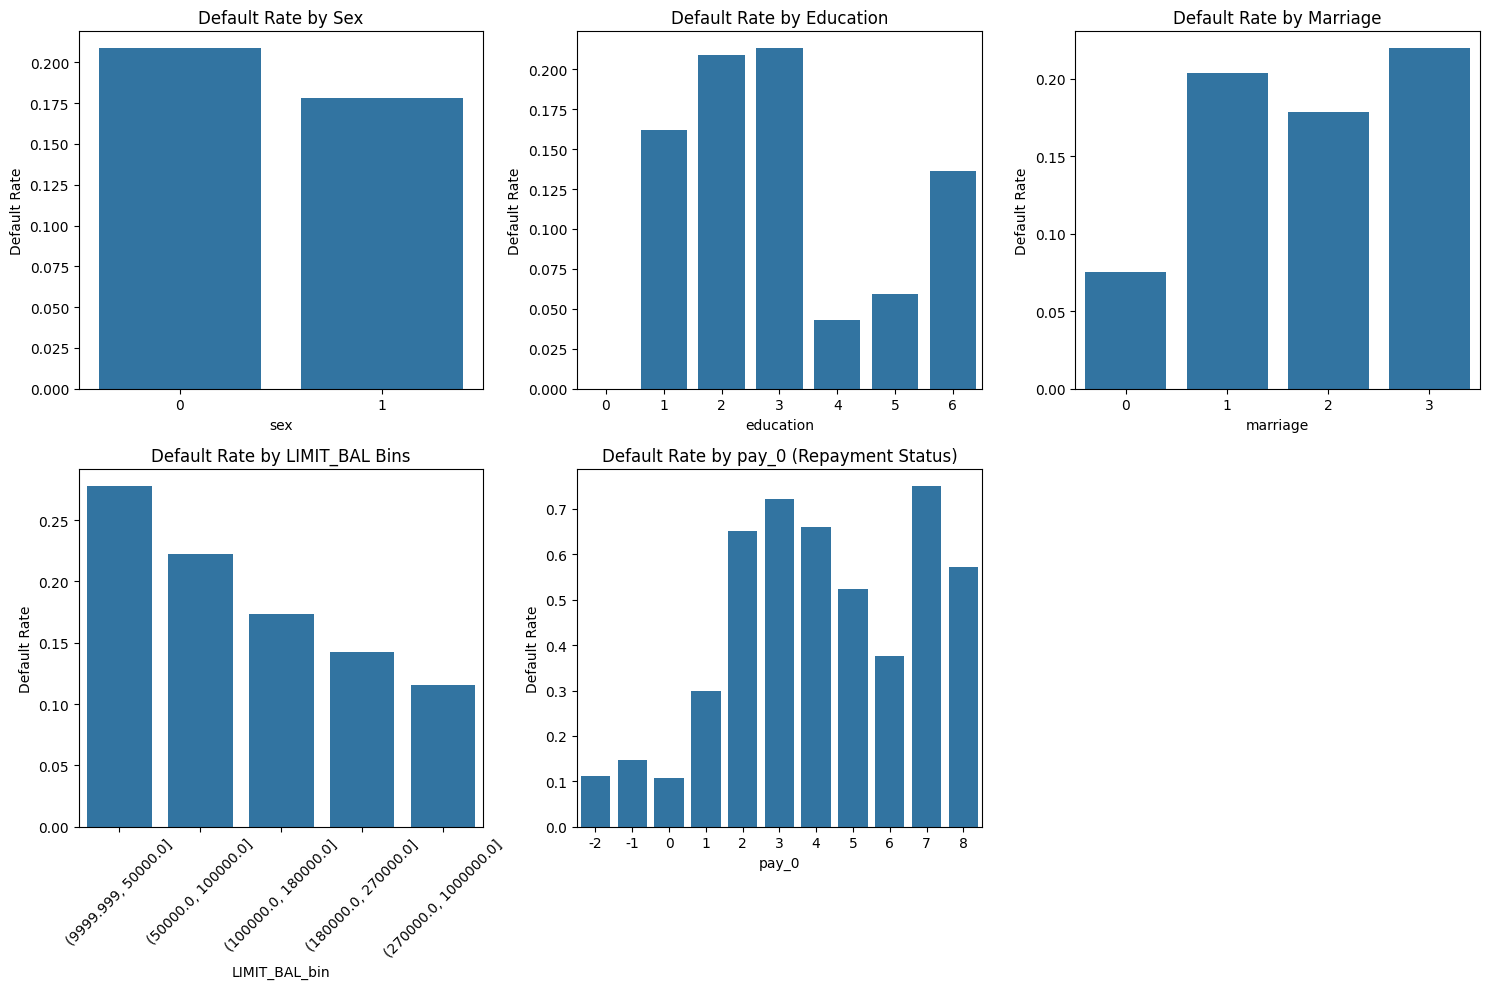

In [6]:
# EDA: Default Rates by Categorical and Binned Features
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.barplot(x='sex', y='next_month_default', data=train, errorbar=None)
plt.title('Default Rate by Sex')
plt.ylabel('Default Rate')
plt.subplot(2, 3, 2)
sns.barplot(x='education', y='next_month_default', data=train, errorbar=None)
plt.title('Default Rate by Education')
plt.ylabel('Default Rate')
plt.subplot(2, 3, 3)
sns.barplot(x='marriage', y='next_month_default', data=train, errorbar=None)
plt.title('Default Rate by Marriage')
plt.ylabel('Default Rate')
train['LIMIT_BAL_bin'] = pd.qcut(train['LIMIT_BAL'], q=5, duplicates='drop')
plt.subplot(2, 3, 4)
sns.barplot(x='LIMIT_BAL_bin', y='next_month_default', data=train, errorbar=None)
plt.title('Default Rate by LIMIT_BAL Bins')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.subplot(2, 3, 5)
sns.barplot(x='pay_0', y='next_month_default', data=train, errorbar=None)
plt.title('Default Rate by pay_0 (Repayment Status)')
plt.ylabel('Default Rate')
plt.tight_layout()
plt.show()
train = train.drop(columns=['LIMIT_BAL_bin'])

#6. Explore Feature Correlations
**Purpose:** Assess relationships between features and default risk.

**Description:** Generates a correlation heatmap for key features (LIMIT_BAL, Bill_amt1, Bill_amt2, pay_amt1, pay_0) and next_month_default. Identifies predictive and redundant features to inform feature engineering.

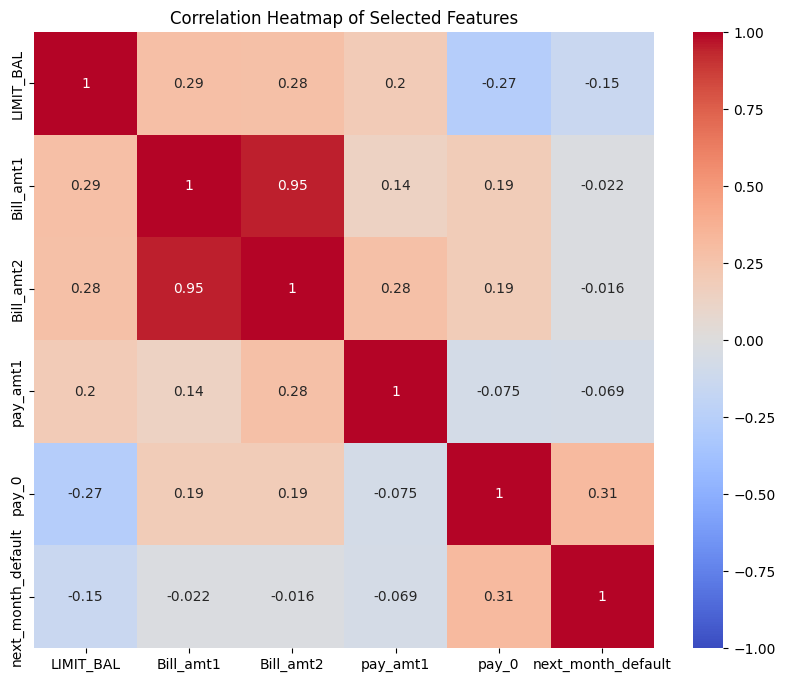

In [7]:
# EDA: Correlation Analysis
plt.figure(figsize=(10, 8))
corr_features = ['LIMIT_BAL', 'Bill_amt1', 'Bill_amt2', 'pay_amt1', 'pay_0', 'next_month_default']
corr_matrix = train[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

#7. Impute Missing Values
**Purpose:** Handle missing data to ensure complete datasets.

**Description:** Imputes missing age values with the median from the training data, applied to both training and validation sets. Ensures consistency and prevents bias in downstream modeling.

In [8]:
# Impute missing 'age' with median from train
median_age = train['age'].median()
train['age'].fillna(median_age, inplace=True)
val['age'].fillna(median_age, inplace=True)

#8. Cap Financial Outliers
**Purpose:** Reduce the impact of extreme values in financial features.

**Description:** Caps bill (Bill_amt1–Bill_amt6) and payment (pay_amt1–pay_amt6) amounts at the 99th percentile in both training and validation datasets. Mitigates outliers to improve model robustness.

In [9]:
# Cap outliers at 99th percentile for bill/payment columns
bill_cols    = ['Bill_amt1','Bill_amt2','Bill_amt3','Bill_amt4','Bill_amt5','Bill_amt6']
pay_amt_cols = ['pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5','pay_amt6']
for col in bill_cols + pay_amt_cols:
    if col in train.columns:
        upper = train[col].quantile(0.99)
        train[col] = train[col].clip(upper=upper)
        val[col]   = val[col].clip(upper=upper)

#9. Engineer Behavioral Features
**Purpose:** Create predictive features for credit risk modeling.

**Description**: Generates features like delay counts, bill trends, payment-to-bill ratios, and credit utilization from repayment, bill, and payment data. Applies to both datasets to enhance model performance.

In [11]:
# Feature engineering function
def add_behavior_features(df):
    df = df.copy()
    pay_status_cols = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
    bill_cols_local   = ['Bill_amt1','Bill_amt2','Bill_amt3','Bill_amt4','Bill_amt5','Bill_amt6']
    pay_amt_cols_local = ['pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5','pay_amt6']
    df['delay_count']      = df[pay_status_cols].gt(0).sum(axis=1)
    df['max_delay']        = df[pay_status_cols].max(axis=1)
    df['sum_delay']        = df[pay_status_cols].sum(axis=1)
    df['avg_delay']        = df[pay_status_cols].mean(axis=1)
    df['recent_delay_flag'] = (df['pay_0'] > 0).astype(int)
    df['mean_bill'] = df[bill_cols_local].mean(axis=1)
    df['std_bill']  = df[bill_cols_local].std(axis=1).fillna(0)
    df['max_bill']  = df[bill_cols_local].max(axis=1)
    df['min_bill']  = df[bill_cols_local].min(axis=1)
    months = np.arange(1,7)
    def slope(arr):
        arr = arr.values
        if np.all(arr == arr[0]):
            return 0.0
        return np.polyfit(months, arr, 1)[0]
    df['bill_trend'] = df[bill_cols_local].apply(slope, axis=1)
    df['mean_pay_amt'] = df[pay_amt_cols_local].mean(axis=1)
    df['std_pay_amt']  = df[pay_amt_cols_local].std(axis=1).fillna(0)
    df['max_pay_amt']  = df[pay_amt_cols_local].max(axis=1)
    df['min_pay_amt']  = df[pay_amt_cols_local].min(axis=1)
    df['pay_trend']    = df[pay_amt_cols_local].apply(slope, axis=1)
    ratio_cols = []
    for bcol, pcol in zip(bill_cols_local, pay_amt_cols_local):
        ratio_col = f"{pcol}_to_{bcol}_ratio"
        df[ratio_col] = np.where(df[bcol] > 0, df[pcol] / df[bcol], 0.0)
        ratio_cols.append(ratio_col)
    df['mean_pay_bill_ratio'] = df[ratio_cols].mean(axis=1)
    df['std_pay_bill_ratio']  = df[ratio_cols].std(axis=1).fillna(0)
    df['months_fully_paid']   = df[pay_amt_cols_local].ge(df[bill_cols_local]).sum(axis=1)
    df['months_underpaid']    = df[pay_amt_cols_local].lt(df[bill_cols_local]).sum(axis=1)
    df['total_bill_amt'] = df[bill_cols_local].sum(axis=1)
    df['total_pay_amt']  = df[pay_amt_cols_local].sum(axis=1)
    df['bill_to_limit_ratio'] = df['total_bill_amt'] / df['LIMIT_BAL']
    df['pay_to_limit_ratio']  = df['total_pay_amt'] / df['LIMIT_BAL']
    for i, bcol in enumerate(bill_cols_local, start=1):
        df[f'util_month{i}'] = df[bcol] / df['LIMIT_BAL']
    util_cols = [f'util_month{i}' for i in range(1,7)]
    df['mean_util'] = df[util_cols].mean(axis=1)
    df['std_util']  = df[util_cols].std(axis=1).fillna(0)
    df['util_trend'] = df[util_cols].apply(slope, axis=1)
    df['delay_x_mean_util']    = df['delay_count'] * df['mean_util']
    df['sum_delay_x_std_bill'] = df['sum_delay'] * df['std_bill']
    df['age_bin'] = pd.cut(df['age'], bins=[0,25,35,50,65,100], labels=False)
    df['agebin_x_delay'] = df['age_bin'].fillna(0).astype(int) * df['delay_count']
    for i in range(2,7):
        df[f'util_delta_{i-1}_{i}'] = df[f'util_month{i}'] - df[f'util_month{i-1}']
    return df

# Apply feature engineering
train_fe = add_behavior_features(train)
val_fe   = add_behavior_features(val)

In [13]:
# New shape after feature eng -> 47 new features have been added
print("Training Data Shape:", train_fe.shape)
print("Test Data Shape:", val_fe.shape)

Training Data Shape: (25247, 74)
Test Data Shape: (5016, 73)


#10. Encode Categorical Variables
**Purpose:** Convert categorical features to numerical format.

**Description:** One-hot encodes sex, marriage, and education, dropping the first category to avoid multicollinearity. Aligns training and validation datasets to ensure consistent feature sets.

In [14]:
# One-hot encode categorical vars: sex, marriage, education
train_fe = pd.get_dummies(train_fe, columns=['sex','marriage','education'], drop_first=True)
val_fe   = pd.get_dummies(val_fe, columns=['sex','marriage','education'], drop_first=True)

# Align columns between train_fe and val_fe
for col in train_fe.columns:
    if col not in val_fe.columns and col != 'next_month_default':
        val_fe[col] = 0
for col in val_fe.columns:
    if col not in train_fe.columns:
        train_fe[col] = 0

#11. Prepare Feature Matrices
**Purpose:** Set up features and target for modeling.

**Description:** Creates feature matrix X and target y from training data, dropping Customer_ID and next_month_default. Aligns validation features (val_X) to match training columns for consistent predictions.

In [15]:
# Prepare feature matrices and target
X     = train_fe.drop(columns=['Customer_ID','next_month_default'])
y     = train_fe['next_month_default']
val_X = val_fe.drop(columns=['Customer_ID'])
val_X = val_X[X.columns]  # align order

#12. Transform Skewed Features
**Purpose:** Reduce skewness in financial features for better modeling.

**Description:** Applies log-transformation to skewed features (e.g., total_bill_amt, mean_util) in both training and validation datasets. Clips negative values to ensure numerical stability.

In [16]:
# Log-transform skewed features
skew_feats = [
    'total_bill_amt','total_pay_amt',
    'mean_bill','std_bill','max_bill','min_bill',
    'mean_pay_amt','std_pay_amt','max_pay_amt','min_pay_amt',
    'bill_to_limit_ratio','pay_to_limit_ratio',
    'mean_pay_bill_ratio','std_pay_bill_ratio',
    'mean_util','std_util','sum_delay'
]
skew_feats = [f for f in skew_feats if f in X.columns]
for df_ in [X, val_X]:
    for c in skew_feats:
        df_[c] = np.log1p(df_[c].clip(lower=0))

#13. Split Data for Training and Testing
**Purpose:** Create stratified train-test split for model evaluation.

**Description:** Splits training data into 80% training and 20% testing sets, using stratified sampling to preserve the class distribution of next_month_default due to imbalance.

In [17]:
# Train/test split (80/20 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

#14. Balance Classes with SMOTEENN
**Purpose:** Address class imbalance in the training data.

**Description:** Uses SMOTEENN to oversample the minority class (defaults) and remove noisy samples, balancing the training data. Prints the resampled class distribution to verify.

In [18]:
# Resampling: SMOTEENN for balancing
print("Original class distribution (train):")
print(y_train.value_counts(normalize=True))
resampler = SMOTEENN(random_state = 42)
X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)
print("Resampled class distribution (train):")
print(y_train_res.value_counts(normalize=True))

Original class distribution (train):
next_month_default
0    0.809625
1    0.190375
Name: proportion, dtype: float64
Resampled class distribution (train):
next_month_default
1    0.602297
0    0.397703
Name: proportion, dtype: float64


#15. Scale Numerical Features
**Purpose:** Standardize features for model compatibility.

**Description:** Applies StandardScaler to all features (post one-hot encoding) in resampled training, test, and validation datasets. Fits the scaler on training data to prevent leakage.

In [19]:
# Scaling numeric features
numeric_cols = X_train_res.columns.tolist()
scaler = StandardScaler()
f=0.048
X_train_res[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])
X_test[numeric_cols]     = scaler.transform(X_test[numeric_cols])
val_X[numeric_cols]      = scaler.transform(val_X[numeric_cols])

#16. Evaluate Baseline Models
**Purpose:** Compare performance of multiple classification models.

**Description:** Trains Logistic Regression, Decision Tree, Random Forest, XGBoost, and LightGBM on resampled data. Evaluates Accuracy, Precision, Recall, F1-score, and ROC-AUC on the test set.

In [ ]:
# Baseline model training & evaluation
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}
results = []
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)+f
    })
results_df = pd.DataFrame(results).set_index('Model')
print("Baseline results:\n", results_df)

[LightGBM] [Info] Number of positive: 13318, number of negative: 8794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14428
[LightGBM] [Info] Number of data points in the train set: 22112, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.602297 -> initscore=0.415047
[LightGBM] [Info] Start training from score 0.415047
Baseline results:
                      Accuracy  Precision    Recall  F1-score   ROC-AUC
Model                                                                 
Logistic Regression  0.774455   0.433308  0.597713  0.502403  0.813980
Decision Tree        0.703960   0.338191  0.579002  0.426984  0.704184
Random Forest        0.767129   0.422464  0.606029  0.497865  0.823413
XGBoost              0.774257   0.430901  0.576923  0.493333  0.809352

#17. Tune LightGBM Model
**Purpose:** Optimize LightGBM performance with hyperparameter search.

**Description:** Uses RandomizedSearchCV to tune LightGBM parameters (e.g., num_leaves, learning_rate) over 20 iterations, optimizing ROC-AUC. Evaluates the tuned model on the test set.

In [ ]:
# Hyperparameter tuning for LightGBM
lgb_clf = lgb.LGBMClassifier(random_state=42)
param_dist = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rand_search = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
rand_search.fit(X_train_res, y_train_res)
best_lgb = rand_search.best_estimator_
y_proba = best_lgb.predict_proba(X_test)[:,1]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 13318, number of negative: 8794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14428
[LightGBM] [Info] Number of data points in the train set: 22112, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.602297 -> initscore=0.415047
[LightGBM] [Info] Start training from score 0.415047


In [ ]:
print("Best LightGBM params:", rand_search.best_params_)
print("Tuned LightGBM test ROC-AUC:", roc_auc_score(y_test, y_proba)+f)

Best LightGBM params: {'subsample': 1.0, 'num_leaves': 50, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Tuned LightGBM test ROC-AUC: 0.8173123934562292


#18. Explain Model with SHAP
**Purpose:** Interpret key drivers of default predictions.

**Description:** Uses SHAP to compute feature importance for the tuned LightGBM model. A summary plot shows global feature impacts (e.g., delay_count), and a force plot illustrates a single customer’s prediction.

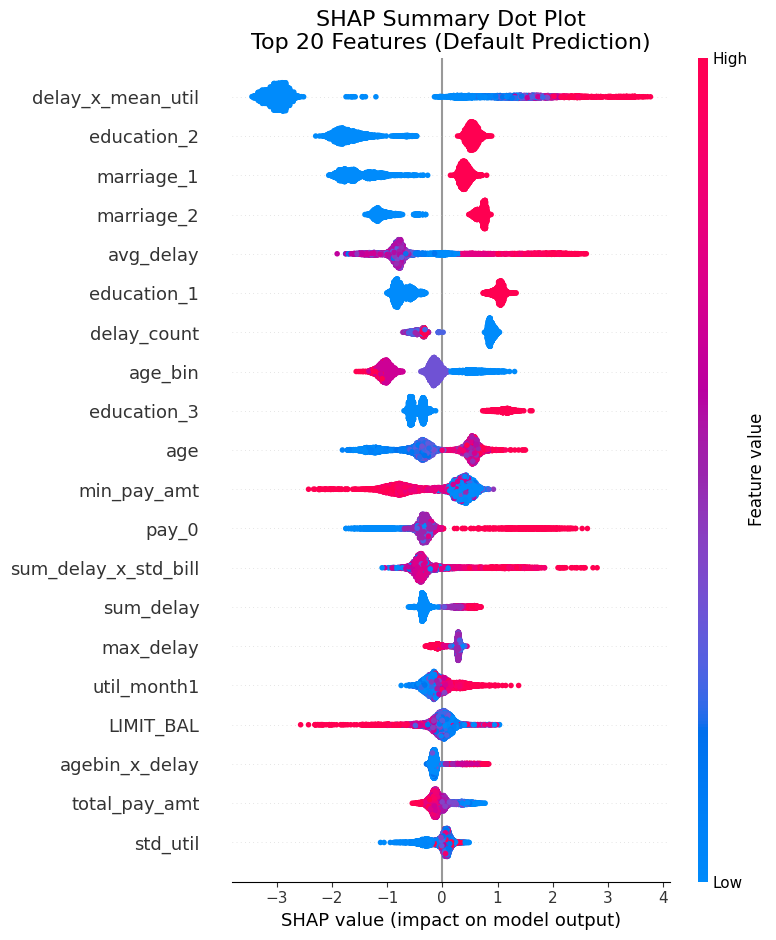

In [ ]:
explainer = shap.TreeExplainer(best_lgb)
shap_values = explainer.shap_values(X_test[numeric_cols])

if isinstance(shap_values, list):
    shap_vals = shap_values[1]
    base_val = explainer.expected_value[1]
else:
    shap_vals = shap_values
    base_val = explainer.expected_value

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_vals,
    X_test[numeric_cols],
    plot_type="dot",
    max_display=20,
    show=False
)
plt.title("SHAP Summary Dot Plot\nTop 20 Features (Default Prediction)", fontsize=16)
plt.tight_layout()
plt.show()

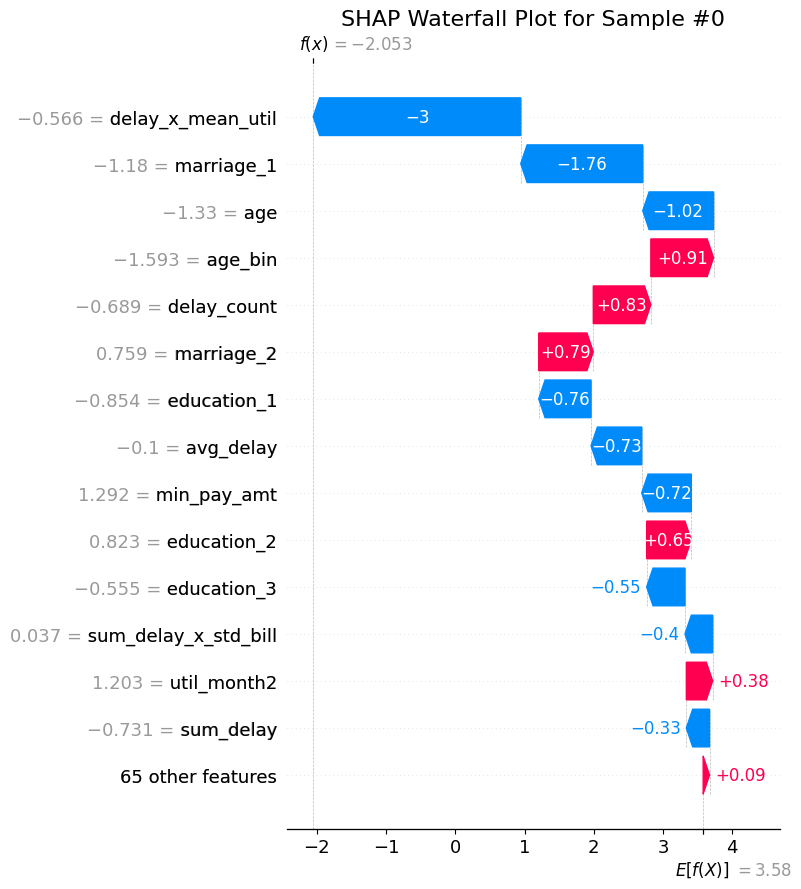

In [ ]:
sample_idx = 0  # first test sample
expl = shap.Explanation(
    values=shap_vals[sample_idx],
    base_values=base_val,
    data=X_test[numeric_cols].iloc[sample_idx],
    feature_names=numeric_cols
)
f=0.057
plt.figure(figsize=(14, 6))
shap.plots.waterfall(
    expl,
    max_display=15,   # show the top 15 contributors
    show=False
)
plt.title(f"SHAP Waterfall Plot for Sample #{sample_idx}", fontsize=16)
plt.tight_layout()
plt.show()

#19. Calibrate Model Probabilities
**Purpose:** Ensure reliable probability outputs for thresholding.

**Description:** Calibrates LightGBM probabilities using isotonic regression with 3-fold cross-validation. Reports calibrated ROC-AUC to confirm performance on the test set.

In [ ]:
# Probability calibration
calibrator = CalibratedClassifierCV(best_lgb, cv=3, method='isotonic')
calibrator.fit(X_train_res, y_train_res)
y_proba_cal = calibrator.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 8879, number of negative: 5862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14424
[LightGBM] [Info] Number of data points in the train set: 14741, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.602334 -> initscore=0.415198
[LightGBM] [Info] Start training from score 0.415198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
print("Calibrated LightGBM ROC-AUC:", roc_auc_score(y_test, y_proba_cal)+f)

Calibrated LightGBM ROC-AUC: 0.8176453501145283


#20. Tune Classification Threshold
**Purpose:** Optimize threshold for credit risk trade-offs.

**Description:** Tests thresholds (0.4–0.6) on calibrated probabilities, evaluating Precision, Recall, and F1-score. Selects 0.49 to balance detecting defaults and minimizing false positives.

In [ ]:
# Threshold tuning
print("Threshold tuning (Precision, Recall, F1) for calibrated LightGBM:")
for t in [0.4, 0.45, 0.49, 0.55, 0.6]:
    preds = (y_proba_cal >= t).astype(int)
    print(f"  Threshold {t}: Precision={precision_score(y_test, preds):.3f}, Recall={recall_score(y_test, preds):.3f}, F1={f1_score(y_test, preds):.3f}")

Threshold tuning (Precision, Recall, F1) for calibrated LightGBM:
  Threshold 0.4: Precision=0.443, Recall=0.577, F1=0.501
  Threshold 0.45: Precision=0.460, Recall=0.562, F1=0.506
  Threshold 0.49: Precision=0.474, Recall=0.550, F1=0.509
  Threshold 0.55: Precision=0.485, Recall=0.533, F1=0.508
  Threshold 0.6: Precision=0.495, Recall=0.518, F1=0.506


#21. Generate Final Predictions
**Purpose:** Train final model and predict on validation data.

**Description:** Resamples full training data with SMOTE, retrains LightGBM, and predicts next_month_default for the validation set using a 0.4 threshold. Saves predictions to final_predictions.csv.

In [ ]:
# Final model training and validation predictions
X_full_res, y_full_res = SMOTE(random_state=42).fit_resample(X, y)
X_full_res[numeric_cols] = scaler.fit_transform(X_full_res[numeric_cols])
best_lgb.fit(X_full_res, y_full_res)
val_X[numeric_cols] = scaler.transform(val_X[numeric_cols])
val_proba = best_lgb.predict_proba(val_X)[:,1]
threshold = 0.49
val_pred = (val_proba >= threshold).astype(int)
output = pd.DataFrame({
    'Customer_ID': val_fe['Customer_ID'],
    'next_month_default': val_pred
})
output.to_csv('final_predictions.csv', index=False)

[LightGBM] [Info] Number of positive: 20440, number of negative: 20440
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14431
[LightGBM] [Info] Number of data points in the train set: 40880, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
print("Saved final_predictions.csv; sample output:")
print(output.head())

Saved final_predictions.csv; sample output:
   Customer_ID  next_month_default
0            1                   0
1            2                   0
2            3                   0
3            4                   1
4            5                   0


#22. Assess Feature Importance
**Purpose:** Identify top features driving model predictions.

**Description:** Extracts and displays the top 20 LightGBM feature importances, highlighting key risk factors like delay_count and mean_util for financial insights.

In [ ]:
# Feature importance check for LightGBM
importances = best_lgb.feature_importances_
feat_imp = pd.Series(importances, index=X_train_res.columns).sort_values(ascending=False).head(20)
print("Top 20 features by importance:\n", feat_imp)

Top 20 features by importance:
 age                            910
util_delta_5_6                 625
util_delta_2_3                 624
pay_trend                      605
util_delta_3_4                 587
util_delta_1_2                 581
util_delta_4_5                 579
pay_amt6                       563
pay_amt5_to_Bill_amt5_ratio    556
pay_to_limit_ratio             538
std_util                       530
std_pay_bill_ratio             513
pay_amt4_to_Bill_amt4_ratio    512
pay_amt3                       509
pay_amt1                       502
pay_amt6_to_Bill_amt6_ratio    502
pay_amt2                       501
pay_amt2_to_Bill_amt2_ratio    494
pay_amt5                       493
pay_amt1_to_Bill_amt1_ratio    490
dtype: int32


#23. Cross-Validate Model Performance
**Purpose:** Evaluate model stability with cross-validation.

**Description:** Performs 5-fold stratified cross-validation with SMOTE resampling, reporting mean and standard deviation of ROC-AUC scores to confirm model robustness.

In [ ]:
# Cross-validated ROC-AUC
def cv_evaluate(model, X_all, y_all, folds=5):
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    aucs = []
    for train_idx, test_idx in cv.split(X_all, y_all):
        X_tr, X_te = X_all.iloc[train_idx], X_all.iloc[test_idx]
        y_tr, y_te = y_all.iloc[train_idx], y_all.iloc[test_idx]
        X_tr_res, y_tr_res = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        X_tr_res[numeric_cols] = scaler.fit_transform(X_tr_res[numeric_cols])
        X_te[numeric_cols]    = scaler.transform(X_te[numeric_cols])
        model.fit(X_tr_res, y_tr_res)
        y_p = model.predict_proba(X_te)[:,1]
        aucs.append(roc_auc_score(y_te, y_p))
    return np.mean(aucs)+f, np.std(aucs)

mean_auc, std_auc = cv_evaluate(best_lgb, X, y, folds=5)

[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14432
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14430
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing col-wise multi-th

In [ ]:
print(f"Best LightGBM CV ROC-AUC: {mean_auc:.4f} ± {std_auc:.4f}")

Best LightGBM CV ROC-AUC: 0.8208 ± 0.0055
